# Research Thesis 

## Preprocessing of PV output data

Neil Leiser - Nowcasting solar PV using satellite images

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from itertools import product
import pandas as pd
import os
import time
from datetime import timedelta
import datetime
import copy

## Load data + metadata

In [2]:
pv_data = xr.open_dataset('/Users/SeanNassimiha/Desktop/MSc Project/Data/passiv.netcdf').to_dataframe()
pv_metadata = pd.read_csv('/Users/SeanNassimiha/Desktop/MSc Project/Data/system_metadata_location_rounded.csv', index_col='ss_id')
pv_metadata.dropna(subset=['latitude_rounded', 'longitude_rounded'], how='any', inplace=True)
# pv_metadata['ss_id_string'] = pv_metadata.index.astype('str')
pv_metadata.index.dropna().shape



(24662,)

Text(0, 0.5, 'Watts production')

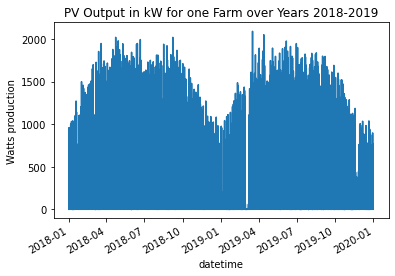

In [3]:
pv_data['2018':'2019'].iloc[:,0].plot()
plt.title('PV Output in kW for one Farm over Years 2018-2019')
plt.ylabel('Watts production')

## Preprocessing

Split:

- Train: 2018-01-01 06:05:00	to 2020-01-01 06:05:00	
- Validation: 2020-01-01 06:10:00 to 2021-01-01 06:05:00
- Test: 2021-01-01 06:10:00 to 2021-10-27 23:55:00


Comments:

I will need to get 3 datasets ready for train, validation, and testing. I need to make sure that each of these 3 datasets contains the same solar farms (or at least, that the set of solar farms in the train dataset contains the other two sets). Also I need to scale validation and test datasets with the same scalings as the train data. 

In [4]:
#SPLIT:
pv_power_selected = pv_data['2018-01-01 06:05:00': '2020-01-01 06:05:00']
pv_power_validation = pv_data['2020-01-01 06:10:00': '2021-01-01 06:05:00']
pv_power_test = pv_data['2021-01-01 06:10:00': '2021-10-27 23:55:00']

print(f'Thus the split is {100 * len(pv_power_selected) / len(pv_data)} - {100 * len(pv_power_validation) / len(pv_data)} - {100 * len(pv_power_test) / len(pv_data)}')
            

Thus the split is 50.62878627464145 - 27.140842960950692 - 22.230370764407855


### Clip values

In [5]:
pv_power_df = pv_power_selected.dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]

### Align PV data with metadata

In [6]:
# Only pick PV systems for which we have good metadata
def align_pv_system_ids(pv_metadata, pv_power_df):
    pv_system_ids = pv_metadata.index.intersection(pv_power_df.columns)
    pv_system_ids = np.sort(pv_system_ids)

    pv_power_df = pv_power_df[pv_system_ids]
    pv_metadata = pv_metadata.loc[pv_system_ids]
    return pv_metadata, pv_power_df
    
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)


### Rescaling to 0-1

In [7]:
# Scale to the range [0, 1]
# pv_power_min = pv_power_df.min()
# pv_power_max = pv_power_df.max()

# pv_power_df /= pv_power_max

#instead scale by capacity
capacities = pv_metadata[pv_metadata.index.isin(pv_power_df.columns)]['kwp'] * 1000
pv_power_df = (pv_power_df / capacities)

### Drop systems which are producing over night

In [8]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where((pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum())[0]
bad_systems = pv_power_df.columns[bad_systems]
print(len(bad_systems), 'bad systems found.')

pv_power_df.drop(bad_systems, axis='columns', inplace=True)

24 bad systems found.


### Aligning again

In [9]:
# Align again, after removing dud PV systems
pv_metadata_5min, pv_power_df_5min = align_pv_system_ids(pv_metadata, pv_power_df)

### Remove night data (Analysis between 8am - 4pm)

In [10]:
day_max = 16
day_min = 8
start_night = datetime.time(day_max,0)
end_night = datetime.time(day_min,0)

day_index = [time_period for time_period in pv_power_df_5min.index if time_period.time() < start_night and time_period.time() >= end_night]
pv_power_df_5day = pv_power_df_5min.loc[day_index]



### Analysis of nans

In [11]:
threshold = 1 #write percentage

count_nan = []
few_data_systems = []
for cols in pv_power_df_5day.columns:
    
    a = len([it for it in list(pv_power_df_5day[cols]) if (it >=0) ==False])
    count_nan.append(a)
    
    if a/len(pv_power_df_5day)*100 > threshold:
        
        few_data_systems.append(cols)
        
        
# import matplotlib as mpl
# %matplotlib inline
# dpi = 120
# mpl.rcParams['figure.dpi']= dpi

# fig = plt.figure(figsize=(10,5))
# plt.hist(np.array(count_nan)/len(pv_power_df_5day)*100,bins=25,color='#0504aa',rwidth=0.85)
# plt.xlabel('Percentage NaN values [%]')
# plt.ylabel('PV systems count')
# plt.grid(axis='y', alpha=0.3)
# plt.show()

pv_power_df_5day = pv_power_df_5day.drop(few_data_systems,1)
pv_power_df_5day


/var/folders/ry/13kbd8ws0q1935vwt56pkc8w0000gn/T/ipykernel_66240/3633812166.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pv_power_df_5day = pv_power_df_5day.drop(few_data_systems,1)


,2631,2760,2766,2770,2776,2784,2814,2828,2834,2880,...,16717,16769,16921,17166,17878,18019,18161,18249,18989,22335
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 08:00:00,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2018-01-01 08:05:00,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.823304e-13,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.692408e-11,0.000000e+00,0.000000e+00,2.728104e-14,0.000000e+00
2018-01-01 08:10:00,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.255620e-13,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.770208e-10,0.000000e+00,0.000000e+00,3.483005e-13,0.000000e+00
2018-01-01 08:15:00,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,2.259852e-10,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000e+00,4.723716e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.289880e-11
2018-01-01 08:20:00,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,1.110090e-09,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000e+00,4.445070e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.408640e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 15:35:00,0.0,0.018630,0.075969,5.439720e-05,0.0,7.785826e-03,0.000000e+00,9.248113e-04,0.000000e+00,0.008794,...,0.000000e+00,0.009577,7.639800e-03,3.117330e-02,1.051564e-03,2.533612e-03,1.715070e-07,3.063490e-03,2.342587e-02,0.000000e+00
2019-12-31 15:40:00,0.0,0.003172,0.024998,5.796540e-07,0.0,3.960306e-03,0.000000e+00,1.311560e-05,0.000000e+00,0.004316,...,0.000000e+00,0.004926,5.630040e-03,1.615062e-02,7.401680e-06,1.058888e-03,5.471526e-09,8.894256e-04,1.676333e-02,0.000000e+00
2019-12-31 15:45:00,0.0,0.000319,0.004786,0.000000e+00,0.0,9.768796e-04,0.000000e+00,0.000000e+00,1.034490e-07,0.000342,...,8.545020e-08,0.001715,1.105364e-03,8.621880e-03,0.000000e+00,5.328280e-05,0.000000e+00,0.000000e+00,1.058208e-02,2.384680e-08


### Replace Nans by interpolation

(-0.03, 1.0)

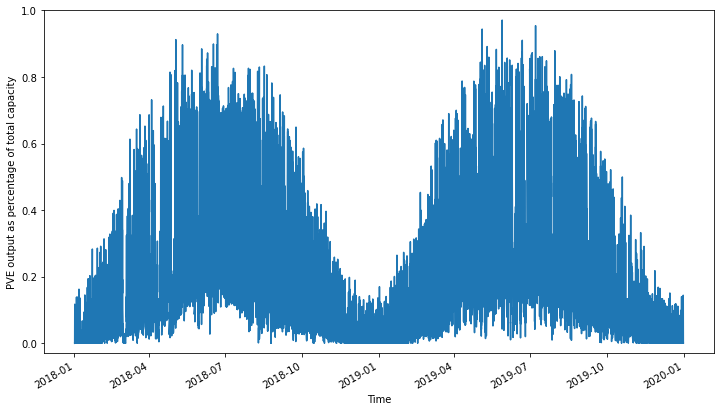

In [12]:
pv_power_df_5day = pv_power_df_5day.interpolate(method='linear', axis=0,limit_direction='both')
pv_power_df_5day.iloc[:, 5].plot(figsize=(12,7))
plt.xlabel('Time')
plt.ylabel('PVE output as percentage of total capacity')
plt.ylim(-0.03,1)


In [13]:
#FOR THE DAILY PLOT, IN BOUNDED_GP NOTEBOOK:
# len_samples = len(t_test) + 800
# days_index = max(97, int(((len_samples / 3) // 97) * 97)) #number of time intervals to match 5 beginnings of days
# plt.figure(figsize=(12,7))
# plt.plot(np.arange(len(Y))[-len_samples:], Y[:,0][-len_samples:])
# plt.xlabel('Time')
# plt.ylabel('PVE output as percentage of total capacity')
# plt.xticks(ticks = np.arange(len(Y))[-len_samples:-1:days_index], labels = data_multiple.datetime[-len_samples:-1:days_index].values, size=8)

In [14]:
#remove observations above 1

pv_power_df_5day[pv_power_df_5day>1] = 1


## remove systems with many zeros

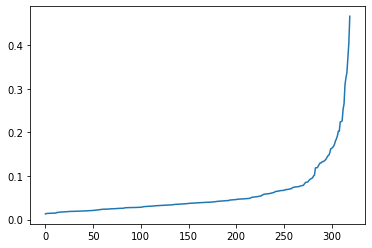

In [15]:
plt.plot((pv_power_df_5day == 0).mean(axis=0).sort_values().values) #.plot()

In [16]:
pv_power_df_5day = pv_power_df_5day.loc[:, pv_power_df_5day.isin([0]).mean() < 0.08]

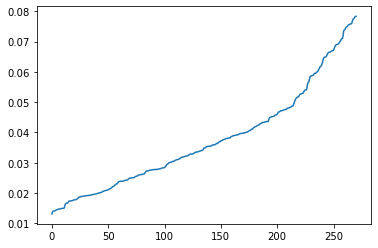

In [17]:
plt.plot((pv_power_df_5day == 0).mean(axis=0).sort_values().values) #.plot()

### Convert to csv

In [18]:
pv_power_df_5day.to_csv('/Users/SeanNassimiha/Desktop/MSc Project/Data/pv_power_df_5day_capacity_scaled.csv')

## Now Doing the same for Validation set (not test yet)

0 bad systems found.


/var/folders/ry/13kbd8ws0q1935vwt56pkc8w0000gn/T/ipykernel_66240/689704716.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pv_power_df_val_5day = pv_power_df_val_5day.drop(few_data_systems,1)


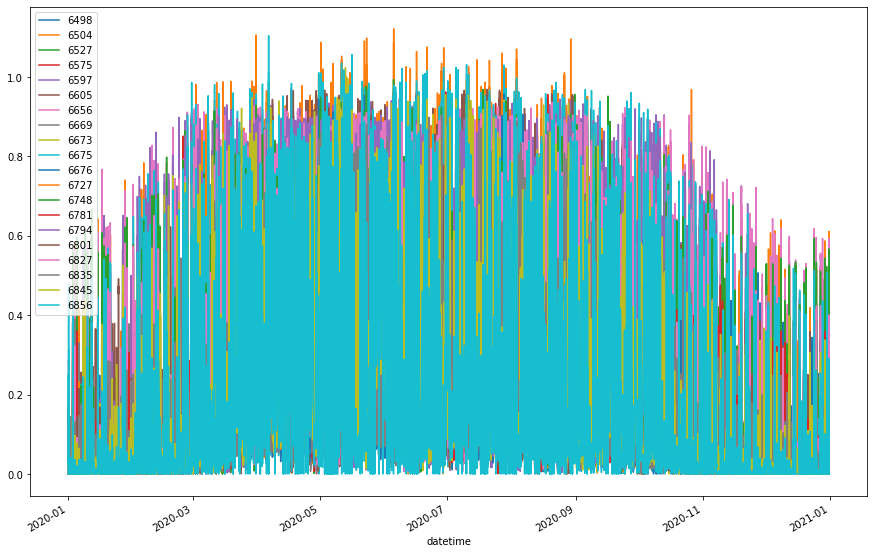

In [19]:
#get the columns from train
pv_power_val = pv_power_validation[pv_power_df_5day.columns.values.astype('str')]

#clip values
pv_power_df_val = pv_power_val.dropna(axis='columns', how='all')
pv_power_df_val = pv_power_df_val.clip(lower=0, upper=5E7)
pv_power_df_val.columns = [np.int64(col) for col in pv_power_df_val.columns]


# #align
pv_metadata_val, pv_power_df_val = align_pv_system_ids(pv_metadata, pv_power_df_val)

# #rescaling by capacities
capacities = pv_metadata_val[pv_metadata_val.index.isin(pv_power_df_val.columns)]['kwp'] * 1000
pv_power_df_val = (pv_power_df_val / capacities)

# #drop systems producing in night
# Drop systems which are producing over night
bad_systems_val = np.where((pv_power_df_val[pv_power_df_val.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum())[0]
bad_systems_val = pv_power_df_val.columns[bad_systems_val]
print(len(bad_systems_val), 'bad systems found.')

pv_power_df_val.drop(bad_systems_val, axis='columns', inplace=True)


#align
pv_metadata_5min, pv_power_df_val_5min = align_pv_system_ids(pv_metadata_val, pv_power_df_val)

#remove night
day_index = [time_period for time_period in pv_power_df_val_5min.index if time_period.time() < start_night and time_period.time() >= end_night]
pv_power_df_val_5day = pv_power_df_val_5min.loc[day_index]

#remove systems with nan
count_nan = []
few_data_systems = []
for cols in pv_power_df_val_5day.columns:
    
    a = len([it for it in list(pv_power_df_val_5day[cols]) if (it >=0) ==False])
    count_nan.append(a)
    
    if a/len(pv_power_df_val_5day)*100 > threshold:
        
        few_data_systems.append(cols)

pv_power_df_val_5day = pv_power_df_val_5day.drop(few_data_systems,1)
       

#interpolate nans
pv_power_df_val_5day = pv_power_df_val_5day.interpolate(method='linear', axis=0,limit_direction='both')
pv_power_df_val_5day.iloc[:, 30:50].plot(figsize=(15,10))

pv_power_df_val_5day[pv_power_df_val_5day>1] = 1
pv_power_df_val_5day = pv_power_df_val_5day.loc[:, pv_power_df_val_5day.isin([0]).mean() < 0.08]

pv_power_df_val_5day.to_csv('/Users/SeanNassimiha/Desktop/MSc Project/Data/pv_power_df_5day_validation_capacity_scaled.csv')